# 神经网络实验

## 第 0 步：多层感知机（Multi Layer Perceptron, MLP）算法

In [1]:
class myMLP3():
    """
        This is a simple implementation for 3-layer neural network (i.e., input layer, hidden layer and output layer)
    """
    def __init__(self, input_layer_size=64, hidden_layer_size=100, output_layer_size=10,
                learning_rate=1, epochs=2000):
        """
            MLP3 initilization
        """
        self.input_layer_size = input_layer_size
        self.hidden_layer_size = hidden_layer_size
        self.output_layer_size = output_layer_size
        self.learning_rate = learning_rate
        self.epochs = epochs

        # 模型参数
        self.params = { 'W1': np.random.randn(self.hidden_layer_size, self.input_layer_size),
           'b1': np.zeros((self.hidden_layer_size, 1)),
           'W2': np.random.randn(self.output_layer_size, self.hidden_layer_size),
           'b2': np.zeros((self.output_layer_size, 1))}

        # 缓存变量：保留前向计算函数产生的汇聚值（非线性变换单元输入）和激励值（非线性变换单元输出）
        self.cache = {}
        
        # 梯度变量：保留反向传播函数计算得到的模型参数W1,b1,W2,b2的更新梯度
        self.grads = {}

    def sigmoid(self, z):
        """
            sigmoid function for nonlinear activation
        """
        a = 1 / (1 + np.exp(-z))
        return a

    def softmax(self, z):
        """
            softmax function for output
        """
        a = np.exp(z) / np.sum(np.exp(z), axis=0)
        return a

    def compute_multiclass_loss(self, Y, Y_hat):
        """
            loss function for multiclass classification
        """
        # 交叉熵损失
        L_sum = np.sum(np.multiply(Y, np.log(Y_hat)))
        sample_num = Y.shape[1]
        L = -(1/sample_num) * L_sum
        return L

    def feed_forward(self, X):
        """
            forward computation
        """
        # 前向计算：计算非线性截点的汇聚值（非线性变换单元输入）和激励值（非线性变换单元输出）
        self.cache['Z1'] = np.matmul(self.params["W1"], X) + self.params["b1"]
        self.cache['A1'] = self.sigmoid(self.cache['Z1'])                                
        self.cache['Z2'] = np.matmul(self.params["W2"], self.cache["A1"]) + self.params["b2"]                     
        self.cache['A2'] = self.softmax(self.cache['Z2'])

    def back_propagate(self, X, Y):
        """
            backward propagation
        """
        # 反向传播：计算模型参数W1,b1,W2,b2的更新梯度
        sample_num = X.shape[1]

        dZ2 = self.cache["A2"] - Y
        dW2 = (1./sample_num) * np.matmul(dZ2, self.cache["A1"].T)
        db2 = (1./sample_num) * np.sum(dZ2, axis=1, keepdims=True)
        
        dA1 = np.matmul(self.params["W2"].T, dZ2)
        dZ1 = dA1 * self.sigmoid(self.cache["Z1"]) * (1 - self.sigmoid(self.cache["Z1"]))
        dW1 = (1./sample_num) * np.matmul(dZ1, X.T)
        db1 = (1./sample_num) * np.sum(dZ1, axis=1, keepdims=True)

        self.grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}
        return self.grads

    def train(self, X, Y):
        """
            MLP3 training
        """
        for i in range(epochs):
            self.feed_forward(X)
            self.back_propagate(X, Y)

            # 参数更新：梯度下降法
            self.params['W2'] = self.params['W2'] - self.learning_rate * self.grads['dW2']
            self.params['b2'] = self.params['b2'] - self.learning_rate * self.grads['db2']
            self.params['W1'] = self.params['W1'] - self.learning_rate * self.grads['dW1']
            self.params['b1'] = self.params['b1'] - self.learning_rate * self.grads['db1']

            if (i % 20 == 0):
                print("Epoch", i, "cost: ", self.compute_multiclass_loss(Y, self.cache["A2"]))
            elif (i==epochs-1):
                print("Epoch", epochs, "cost: ", self.compute_multiclass_loss(Y, self.cache["A2"]))
        #return self.params

    def predict(self, X):
        """
            MLP3 prediction
        """
        self.feed_forward(X)
        return np.argmax(self.cache["A2"], axis=0)

## 第 1 步：准备实验数据 

In [2]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import OneHotEncoder

In [3]:
digits_dataset = load_digits()

X = minmax_scale(digits_dataset.data) # 特征逐维归一化
ohe = OneHotEncoder()
y = np.array(ohe.fit_transform(digits_dataset.target.reshape(-1,1)).todense()) # 将类标签转变为one hot型变量

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)
 
np.random.seed(1)
shuffle_index = np.random.permutation(X_train.shape[0]) # 对训练集打乱顺序 
X_train = X_train[shuffle_index, :]
y_train = y_train[shuffle_index, :]

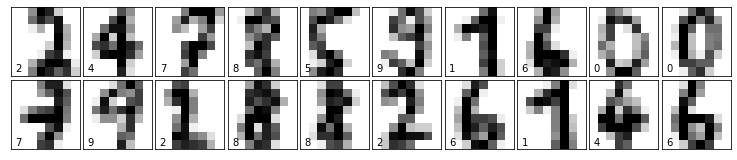

In [4]:
# 绘制样例图片
import matplotlib.pyplot as plt
%matplotlib inline
 
fig = plt.figure(figsize=(10, 2))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(20):
    ax = fig.add_subplot(2, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(X_train[i,:].reshape(8,8), cmap=plt.cm.binary, interpolation='nearest')
    ax.text(0, 7, '{}'.format(np.argwhere(y_train[i,:]==1)[0][0]))

plt.show()

## 第 2 步：使用反向传播（Back propagation, BP）算法训练模型

In [5]:
# 实验参数：选择不同的隐含层结点个数、学习率和训练循环迭代次数
hidden_layer_size = 100 # 隐含层结点个数
learning_rate = 1 # 学习率
epochs = 200 # BP算法循环迭代次数

input_layer_size = X_train.shape[1]  # 输入层结点数，等于64 （8*8图像像素）
output_layer_size = y_train.shape[1] # 输出层结点数，等于10 （0,1,...,9个类别） 

# 模型初始化及训练
mlp3 = myMLP3(input_layer_size, hidden_layer_size, output_layer_size, learning_rate, epochs) # 模型初始化
mlp3.train(X_train.T, y_train.T) # 模型训练

Epoch 0 cost:  14.688652865179417
Epoch 20 cost:  0.8245247058208665
Epoch 40 cost:  0.40402247012741915
Epoch 60 cost:  0.26273335749492155
Epoch 80 cost:  0.20847926641516004
Epoch 100 cost:  0.17900463964161958
Epoch 120 cost:  0.15806566509070102
Epoch 140 cost:  0.14216942865720078
Epoch 160 cost:  0.1295482583554408
Epoch 180 cost:  0.11919695227463499
Epoch 200 cost:  0.11090018825265255


## 第 3 步：模型测试并输出测试结果

In [6]:
# 模型测试
predictions = mlp3.predict(X_test.T) # 预测标签
labels = np.argmax(y_test.T, axis=0) # 标答标签

print('confusion matrix: \n', confusion_matrix(labels, predictions)) # 输出分类混淆矩阵
print('\nclassification report: \n', classification_report(labels, predictions)) # 输出分类报告

confusion matrix: 
 [[20  0  0  0  0  0  0  0  0  0]
 [ 0 18  0  0  0  0  1  0  0  0]
 [ 0  0 21  0  0  0  0  0  0  0]
 [ 0  0  0 22  0  0  0  0  0  0]
 [ 0  0  0  0 18  0  0  0  0  0]
 [ 0  0  0  0  0 17  0  0  0  0]
 [ 0  0  0  0  0  0 16  0  0  0]
 [ 0  0  0  1  0  0  0 20  0  0]
 [ 0  0  0  0  0  1  0  0 14  0]
 [ 0  0  0  0  0  1  0  0  0 10]]

classification report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      0.95      0.97        19
           2       1.00      1.00      1.00        21
           3       0.96      1.00      0.98        22
           4       1.00      1.00      1.00        18
           5       0.89      1.00      0.94        17
           6       0.94      1.00      0.97        16
           7       1.00      0.95      0.98        21
           8       1.00      0.93      0.97        15
           9       1.00      0.91      0.95        11

    accuracy               

## 第 4 步：自选测试样本，用学习得到的MLP进行分类

selected image category is 0


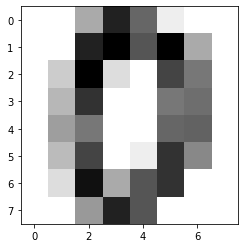

In [7]:
# 实验参数：自选其他的图像，然后用学习得到的MLP分类器进行预测，比对预测结果与实际结果的一致性
new_idx = 0;
assert my_idx in range(y.shape[0])
X_new = X[new_idx]
y_new = y[new_idx]
print('selected image category is %d' % np.where(y_new==1)[0][0])
plt.imshow(X_new.reshape(8,8), cmap=plt.cm.binary, interpolation='nearest')
plt.show()

In [8]:
y_predict = mlp3.predict(my_X.reshape(-1,1))
print('MLP predicted category is %d' % y_predictprediction)

MLP predicted category is 0
